In [1]:
import numpy as np
import osmnx as ox

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 40
symm = False

place = "Pacifica, CA, USA"
G, Adj, Dist = mf.dist_matrix_osmnx(place)
mtype = "dist_pac"
A = Dist
m = n = A.shape[0]

As = {'dist' : A}

diam_G = A.max()
w_min = A[A>0].min()
print(m, diam_G, w_min, (Adj>0).sum())

degrees: {0: 0, 1: 4, 2: 234, 3: 49, 4: 53, 5: 44, 6: 469, 7: 5, 8: 71, 9: 0, 10: 2}
931 52.0 0.5 2395


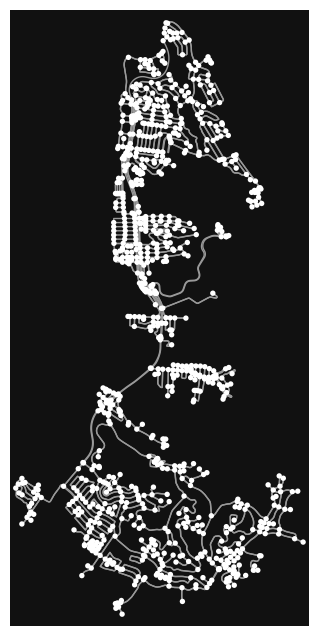

In [4]:
fig, ax = ox.plot_graph(G)

In [5]:
eps_ff = {'bcd':0.005, 'als':0.01}
eps = {'bcd':0.007, 'als':0.01}

method = 'bcd'
svds_v0 = True
max_iters_ff = {'bcd':2, 'als':2}
max_iters = 3*10**3
grref_max_iters = 5000
PSD = False
refined = True
symm = np.allclose(A, A.T)
print(f"{symm=}")

filename = "%s_r%d_%d"%(mtype, rank, n)

symm=True


In [6]:
num_levels = int(np.ceil(np.log2(min(m,n)))+1)
print(f"{num_levels=}")

num_levels=11


In [7]:
info = {}
methods = ['als', 'bcd']

In [8]:
ranks = mf.uniform_ranks(rank, num_levels) 
print(ranks)

[4 4 4 4 4 4 4 3 3 3 3]


In [9]:
hpart = mf.random_hpartition(m, n, num_levels=1, symm=symm, perm=False)
B1, C1 = mf.single_level_factor_fit(A, np.array([rank]), hpart, level=0, symm=symm, PSD=PSD)[:2]
info['LR'] = {'loss':[mf.rel_diff(B1 @C1.T, den=A)]}
print(info['LR']['loss'])

[0.010017847048813212]


# Spectral partitioning + greedy refinement

In [10]:
hat_A = mf.MLRMatrix()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        PSD=PSD, grref_max_iters=grref_max_iters)

B0, C0 = copy.deepcopy(hat_A.B), copy.deepcopy(hat_A.C)

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/mlrfit-0.0.1-py3.9.egg/mlrfit/utils.py:433: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


* level=0, losses[0]=0.083, losses[-1]=0.083, len(losses)=2, [4]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


* level=1, losses[0]=0.047, losses[-1]=0.046, len(losses)=2, [4 4]
* level=2, losses[0]=0.033, losses[-1]=0.032, len(losses)=2, [4 4 4]
* level=3, losses[0]=0.029, losses[-1]=0.029, len(losses)=2, [4 4 4 4]
* level=4, losses[0]=0.028, losses[-1]=0.027, len(losses)=2, [4 4 4 4 4]
* level=5, losses[0]=0.027, losses[-1]=0.027, len(losses)=2, [4 4 4 4 4 4]
* level=6, losses[0]=0.026, losses[-1]=0.026, len(losses)=2, [4 4 4 4 4 4 4]
* level=7, losses[0]=0.026, losses[-1]=0.026, len(losses)=2, [4 4 4 4 4 4 4 3]
* level=8, losses[0]=0.026, losses[-1]=0.025, len(losses)=2, [4 4 4 4 4 4 4 3 3]
* level=9, losses[0]=0.025, losses[-1]=0.025, len(losses)=2, [4 4 4 4 4 4 4 3 3 3]
* level=10, losses[0]=0.025, losses[-1]=0.025, len(losses)=2, [4 4 4 4 4 4 4 3 3 3 3]
level=10, loss=0.024790618083508808


# Rank allocation comparison

In [11]:
for method in  methods:
    start_time = time.time()
    hat_A.B = B0; hat_A.C = C0
    losses, epochs, ranks_history = hat_A.rank_alloc(A, ranks, hat_A.hpart, method=method, freq=1,\
                    eps=eps[method], eps_ff=eps_ff[method], max_iters=max_iters, PSD=PSD, symm=symm,\
                    max_iters_ff=max_iters_ff[method], warm_start=False)
    m_time = time.time() - start_time
    info[method] = {'loss':losses, "time":m_time, 'epochs':epochs}
    print(f"{method:12s}, {losses[0]=:.6f}, {losses[-1]=:.6f}, {m_time=:.2f}, {ranks_history[-1]}")

itr=0, t=3, losses[0]=0.03666678787893269, losses[-1]=0.02954956104437637, [4 4 4 4 4 4 4 3 3 3 3]
itr=1, t=6, 0.019921956767259566, [5 4 4 4 4 4 4 3 3 2 3]
itr=2, t=9, 0.015426067107990172, [6 4 4 4 4 4 4 3 3 2 2]
itr=3, t=12, 0.012993908584789719, [7 4 4 4 4 4 4 3 3 2 1]
itr=4, t=15, 0.011610160466571992, [8 4 4 4 4 4 4 3 3 2 0]
itr=5, t=18, 0.010271103621313364, [9 4 4 4 4 4 4 3 3 1 0]
itr=6, t=21, 0.009290268651938662, [10  4  4  4  4  4  4  3  3  0  0]
itr=7, t=24, 0.008304718794484082, [11  4  4  4  4  4  4  3  2  0  0]
itr=8, t=27, 0.007383295649784992, [12  4  4  4  4  4  4  3  1  0  0]
itr=9, t=30, 0.0065153131916808405, [13  4  4  4  4  4  4  2  1  0  0]
itr=10, t=33, 0.005858798393740091, [13  5  4  4  4  4  4  2  0  0  0]
itr=11, t=36, 0.005412840498849386, [14  5  4  4  4  4  4  1  0  0  0]
itr=12, t=39, 0.0050341645333536605, [14  6  4  4  4  4  3  1  0  0  0]
itr=13, t=42, 0.004720335130692243, [14  7  4  4  4  4  2  1  0  0  0]
itr=14, t=45, 0.004475094462927983, [15  7

als  , num_iters= 61, loss=0.00407286
bcd  , num_iters= 54, loss=0.00376308


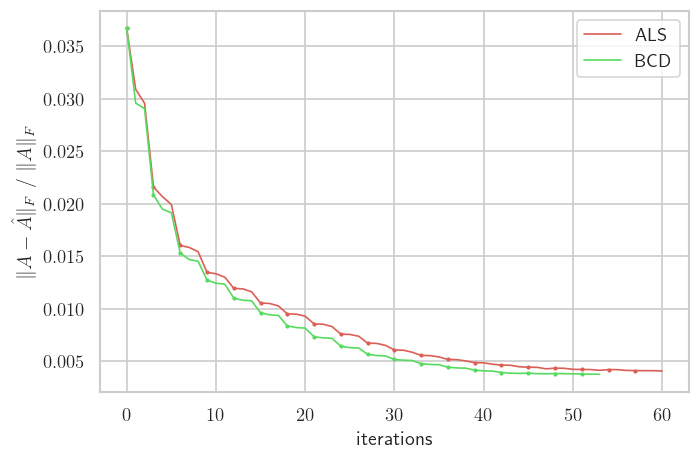

In [12]:
sns.set_theme(style="whitegrid")
plt.rcParams['text.usetex'] = True
labels = methods
cmp = sns.color_palette("hls", len(labels)+1)
dpi = 120
fig, axs = plt.subplots(1, figsize=(6,4), dpi=dpi)
for i, method in enumerate(labels):
    num_iters = len(info[method]['loss'])
    print(f"{method:5s}, {num_iters=:3d}, loss={info[method]['loss'][-1]:.8f}")
    axs.plot(info[method]['loss'], label=method.upper(), lw=1, color=cmp[i])
    if 'epochs' in info[method]:
        axs.plot(info[method]['epochs'][:-1], np.array(info[method]['loss'])[info[method]['epochs'][:-1]], \
                    marker='.', markersize=3, ls="", color=cmp[i])
    
axs.grid(True)
axs.legend()
axs.tick_params(axis='both', which='major', labelsize=11)
axs.tick_params(axis='both', which='minor', labelsize=11)
axs.set_ylabel(r'${\|A-\hat A\|_F}~/~{\|A\|_F}$')
axs.set_xlabel('iterations')
fig.tight_layout()
plt.show()

In [13]:
for i, algo in enumerate(info.keys()):
    print(f"{algo:14s} {info[algo]['loss'][-1]}")

LR             0.010017847048813212
als            0.00407286441416007
bcd            0.0037630813294580313
